In [1]:
import torch
import torchvision
import numpy as np
from torch import nn
from torchvision import transforms
import matplotlib.pyplot as plt


## Task 1: Basics

In [2]:
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 155MB/s]


In [3]:
!unzip TestDataSet.zip

Archive:  TestDataSet.zip
   creating: TestDataSet/
   creating: TestDataSet/n02795169/
  inflating: __MACOSX/TestDataSet/._n02795169  
   creating: TestDataSet/n02769748/
  inflating: __MACOSX/TestDataSet/._n02769748  
   creating: TestDataSet/n02834397/
  inflating: __MACOSX/TestDataSet/._n02834397  
   creating: TestDataSet/n02917067/
  inflating: __MACOSX/TestDataSet/._n02917067  
   creating: TestDataSet/n02808304/
  inflating: __MACOSX/TestDataSet/._n02808304  
   creating: TestDataSet/n03016953/
  inflating: __MACOSX/TestDataSet/._n03016953  
   creating: TestDataSet/n02793495/
  inflating: __MACOSX/TestDataSet/._n02793495  
   creating: TestDataSet/n02814533/
  inflating: __MACOSX/TestDataSet/._n02814533  
   creating: TestDataSet/n02837789/
  inflating: __MACOSX/TestDataSet/._n02837789  
   creating: TestDataSet/n02840245/
  inflating: __MACOSX/TestDataSet/._n02840245  
   creating: TestDataSet/n02992211/
  inflating: __MACOSX/TestDataSet/._n02992211  
   creating: TestDataSet

In [4]:
# preprocess images in TestDataSet
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])
plain_transforms = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize(mean=mean_norms,
std=std_norms)
])
dataset_path = "./TestDataSet"
dataset = torchvision.datasets.ImageFolder(root=dataset_path,
transform=plain_transforms)

data_loader = torch.utils.data.DataLoader(dataset, batch_size=5,)

In [5]:
import json

# Open and read the JSON file
with open('./TestDataSet/labels_list.json', 'r') as file:
    labels = json.load(file)

# Print the data
print(labels)

['401: accordion', '402: acoustic guitar', '403: aircraft carrier', '404: airliner', '405: airship', '406: altar', '407: ambulance', '408: amphibian', '409: analog clock', '410: apiary', '411: apron', '412: ashcan', '413: assault rifle', '414: backpack', '415: bakery', '416: balance beam', '417: balloon', '418: ballpoint', '419: Band Aid', '420: banjo', '421: bannister', '422: barbell', '423: barber chair', '424: barbershop', '425: barn', '426: barometer', '427: barrel', '428: barrow', '429: baseball', '430: basketball', '431: bassinet', '432: bassoon', '433: bathing cap', '434: bath towel', '435: bathtub', '436: beach wagon', '437: beacon', '438: beaker', '439: bearskin', '440: beer bottle', '441: beer glass', '442: bell cote', '443: bib', '444: bicycle-built-for-two', '445: bikini', '446: binder', '447: binoculars', '448: birdhouse', '449: boathouse', '450: bobsled', '451: bolo tie', '452: bonnet', '453: bookcase', '454: bookshop', '455: bottlecap', '456: bow', '457: bow tie', '458: 

In [21]:
def get_accuracies(model, data_loader):
  model = model.to(device)
  correct_samples = 0
  top5_correct_samples = 0
  num_samples = 0
  accuracy = 0
  top5_acc = 0

  for step, (images, targets) in enumerate(data_loader):
    model.eval()
    images, targets = images.to(device), targets.to(device)
    with torch.no_grad():
      outputs = model(images)
    correct_label = int(labels[step][:3])
    # calculate top1 accuracy
    _, preds = torch.max(outputs, dim=1)
    correct_samples += preds.eq(correct_label).sum().item()
    # calulate top5 accuracy
    top5_preds = torch.topk(outputs, 5).indices
    top5_correct_samples += torch.isin(top5_preds, correct_label).sum().item()
    num_samples += images.size(0)

  accuracy = 100.0 * correct_samples / num_samples
  top5_acc = 100.0 * top5_correct_samples / num_samples
  print(f"top1 accuracy: {accuracy:.2f}%")
  print(f"top5 accuracy: {top5_acc:.2f}%")
  return accuracy, top5_acc




In [ ]:
acc, top5acc = get_accuracies(pretrained_model, data_loader)

top1 accuracy: 76.00%
top5 accuracy: 94.20%


## Task 2: Pixel-Wise Attacks

In [7]:
# # https://www.kaggle.com/code/haxothermic/fgsm-against-resnet-50-on-cifar-10, modified to keep l_inf < epsilon


def fgsm_attack(model, criterion, images, labels, device, epsilon=0.02):
  # Make sure model is in evaluation mode
  model.eval()

  # Save the original images for comparison
  original_images = images.clone().detach()

  # Enable gradient recording
  images.requires_grad_(True)

  # Forward pass
  outputs = model(images)


  loss = criterion(outputs, labels)
  # Backward pass to get gradients
  model.zero_grad()
  loss.backward()

  # Get the sign of the gradients
  sign_data_grad = torch.sign(images.grad.data)

  perturbed_images = images + epsilon * sign_data_grad

  # Calculate the final L∞ norm
  l_inf = torch.max(torch.abs(perturbed_images - original_images)).item()
  assert l_inf <= epsilon + 1e-6, f"Attack failed: max L∞ distance {l_inf} exceeds {epsilon}"

  perturbed_images = torch.clamp(perturbed_images, 0, 1)

  return perturbed_images, sign_data_grad


In [8]:
def show_img(images, adversarial_images, adversarial_outputs, toCPU=False):
  pred_num, top5_preds = torch.topk(adversarial_outputs, 5)
  for idx in range(len(images)):
    if 401 not in top5_preds[idx]:
      plt.figure()
      f, axis = plt.subplots(1,3, figsize=(8, 4))
      axis[0].imshow(images[idx].cpu().T.data.numpy())
      axis[0].set_title("Original")
      axis[1].imshow(adversarial_images[idx].cpu().T.data.numpy())
      axis[1].set_title("Adversarial")
      if toCPU:
        axis[2].bar(["".join(item) for item in top5_preds[idx].detach().cpu().numpy().astype(str)], pred_num[idx].detach().cpu().numpy())
      else:
        axis[2].bar(["".join(item) for item in top5_preds[idx].detach().numpy().astype(str)], pred_num[idx].detach().numpy())
      axis[2].set_title("Predictions")
      plt.show()

<ipython-input-7-476bbe758f5b>:7: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3725.)
  axis[0].imshow(images[idx].cpu().T.data.numpy())


<Figure size 640x480 with 0 Axes>

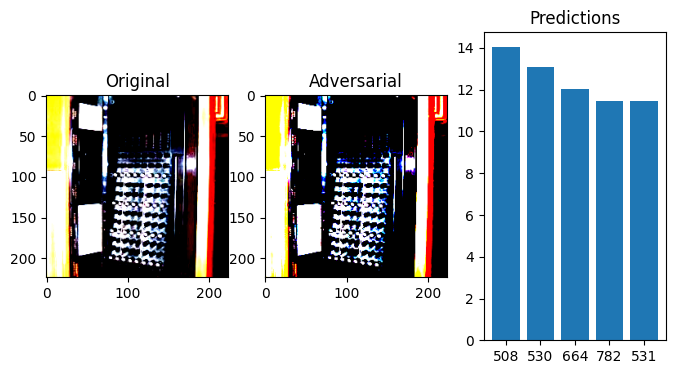

In [ ]:
# create adversarial images and save as a dataset
criterion = nn.CrossEntropyLoss()
epsilon = 0.02
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
adversarial_correct = 0
attack_success = 0
total = 0
AdversarialTestSet1 = [[] for _ in range(5*len(data_loader))]
for step, (images, targets) in enumerate(data_loader):
  adversarial_images, _ = fgsm_attack(pretrained_model, criterion, images, targets, device, epsilon)

  for idx in range(len(adversarial_images)):
    adversarial_images[idx] = plain_transforms(transforms.functional.to_pil_image(adversarial_images[idx]))
    AdversarialTestSet1[step*5+idx].append(adversarial_images[idx])
    AdversarialTestSet1[step*5+idx].append(targets[idx])
  adversarial_outputs = pretrained_model(adversarial_images)
  if step == 0:
    show_img(images, adversarial_images, adversarial_outputs)



In [ ]:
adv_data_loader = torch.utils.data.DataLoader(AdversarialTestSet1, batch_size=5,)

In [ ]:
adv1_acc, adv1_top5acc = get_accuracies(pretrained_model, adv_data_loader)


top1 accuracy: 44.40%
top5 accuracy: 66.20%


## Task 3: Improved Attacks

In [9]:

def improved_attack(model, criterion, images, labels, device, epsilon=0.02, alpha=0.002, iterations=10, target_class=None):
    model.eval()

    images = images.to(device)
    labels = labels.to(device)

    original_images = images.clone().detach()
    perturbed_images = original_images.clone().detach()

    for i in range(iterations):
        perturbed_images.requires_grad_(True)
        outputs = model(perturbed_images)

        if target_class is not None:
            targeted_labels = torch.full_like(labels, target_class)
            if isinstance(criterion, nn.CrossEntropyLoss):
                loss = criterion(outputs, targeted_labels)
            else:
                one_hot_targets = torch.zeros_like(outputs)
                one_hot_targets.scatter_(1, targeted_labels.unsqueeze(1), 1)
                loss = criterion(outputs, one_hot_targets)
            loss = -loss
        else:
            if isinstance(criterion, nn.CrossEntropyLoss):
                loss = criterion(outputs, labels)
            else:
                one_hot_targets = torch.zeros_like(outputs)
                one_hot_targets.scatter_(1, labels.unsqueeze(1), 1)
                loss = criterion(outputs, one_hot_targets)

        model.zero_grad()
        loss.backward()
        grad_sign = torch.sign(perturbed_images.grad.data)

        perturbed_images = perturbed_images.detach() + alpha * grad_sign

        # Clamp perturbation in normalized range (your images are in [-2.1179, 2.6400])
        delta = torch.clamp(perturbed_images - original_images, -epsilon, epsilon)
        perturbed_images = torch.clamp(original_images + delta, -2.1179, 2.6400).detach()

        perturbation = perturbed_images - original_images
        l_inf = torch.max(torch.abs(perturbation)).item()
        # print(f"Iteration {i+1}/{iterations} - L∞ distance: {l_inf:.6f}")

    # Final check
    perturbation = perturbed_images - original_images
    l_inf = torch.max(torch.abs(perturbation)).item()
    if l_inf > epsilon + 1e-6:
        print(f"WARNING: Final L∞ distance {l_inf:.6f} exceeds epsilon {epsilon}")

    return perturbed_images, perturbation




In [ ]:
# criterion = nn.CrossEntropyLoss()
# epsilon = 0.02
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# adversarial_correct = 0
# attack_success = 0
# total = 0
# pretrained_model = pretrained_model.to(device)

# # For visualization and analysis
# targeted_success_rate = 0
# untargeted_success_rate = 0

# # Collect adversarial images and labels here
# adv2_images_list = []
# adv2_labels_list = []

# # Choose a target class (e.g., 0 - could be 'plane' in CIFAR-10)
# target_class = 0

# for step, (images, targets) in enumerate(data_loader):
#     images, targets = images.to(device), targets.to(device)

#     # Apply FGSM attack
#     fgsm_adversarial_images, fgsm_perturbation = fgsm_attack(
#         pretrained_model,
#         criterion,
#         images,
#         targets,
#         device,
#         epsilon=epsilon
#     )

#     # Apply the improved targeted attack
#     improved_adversarial_images, improved_perturbation = improved_attack(
#         pretrained_model,
#         criterion,
#         images,
#         targets,
#         device,
#         target_class=target_class,  # Set to None to use (true_label + 1) % num_classes
#         epsilon=epsilon,
#         alpha=0.002,  # Step size as fraction of epsilon
#         iterations=10
#     )

#     # Combine both attacks' adversarial images for testing
#     combined_adversarial_images = torch.cat((fgsm_adversarial_images, improved_adversarial_images), dim=0)
#     combined_labels = torch.cat((targets, targets), dim=0)  # Same labels for both adversarial types

#     # Store adversarial images and labels into lists
#     adv2_images_list.append(combined_adversarial_images.cpu())
#     adv2_labels_list.append(combined_labels.cpu())

#     # Get model predictions on both adversarial examples (FGSM + Improved)
#     with torch.no_grad():
#         combined_adversarial_outputs = pretrained_model(combined_adversarial_images)
#         _, combined_adv_predicted = torch.max(combined_adversarial_outputs.data, 1)

#         # Untargeted success rate
#         combined_untargeted_success = (combined_adv_predicted != combined_labels).sum().item()
#         untargeted_success_rate += combined_untargeted_success

#         # Targeted success rate
#         if target_class is not None:
#             combined_targeted_labels = torch.full_like(combined_labels, target_class)
#         else:
#             combined_targeted_labels = (combined_labels + 1) % combined_adversarial_outputs.shape[1]

#         combined_targeted_success = (combined_adv_predicted == combined_targeted_labels).sum().item()
#         targeted_success_rate += combined_targeted_success

#         total += combined_labels.size(0)

#     # Visualize the first batch (if needed)
#     if step == 0:
#         show_img(images, combined_adversarial_images, combined_adversarial_outputs, True)




<Figure size 640x480 with 0 Axes>

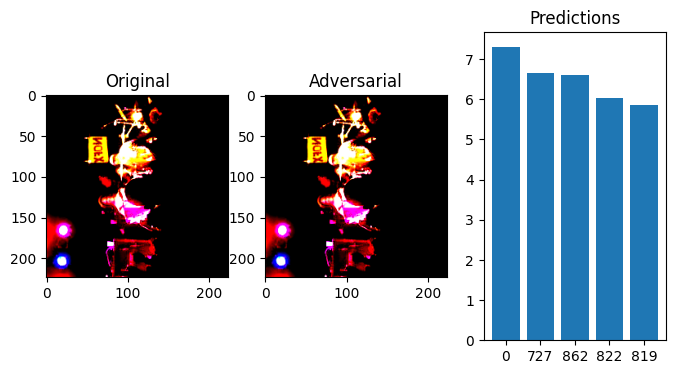

<Figure size 640x480 with 0 Axes>

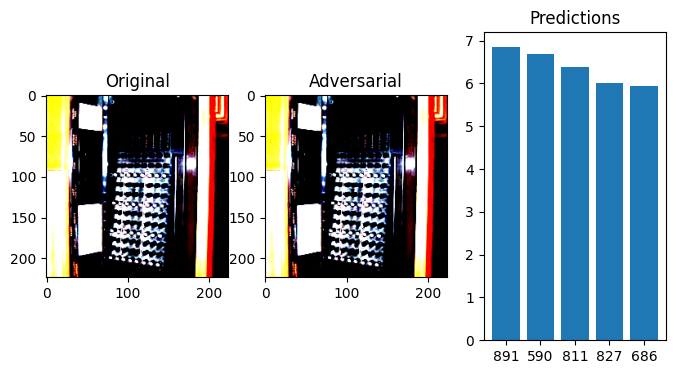

In [17]:
criterion = nn.CrossEntropyLoss()
epsilon = 0.02
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
adversarial_correct = 0
attack_success = 0
total = 0
pretrained_model = pretrained_model.to(device)

# For visualization and analysis
targeted_success_rate = 0
untargeted_success_rate = 0

# Collect adversarial images and labels here
adv2_images_list = []
adv2_labels_list = []

# Choose a target class (e.g., 0 - could be 'plane' in CIFAR-10)
target_class = 0

for step, (images, targets) in enumerate(data_loader):
    images, targets = images.to(device), targets.to(device)

    # Apply the improved targeted attack
    improved_adversarial_images, improved_perturbation = improved_attack(
        pretrained_model,
        criterion,
        images,
        targets,
        device,
        target_class=target_class,  # Set to None to use (true_label + 1) % num_classes
        epsilon=epsilon,
        alpha=0.002,  # Step size as fraction of epsilon
        iterations=10
    )

    # Store adversarial images and labels into lists
    adv2_images_list.append(improved_adversarial_images.cpu())
    adv2_labels_list.append(targets.cpu())

    # Get model predictions on the adversarial examples (Improved Attack)
    with torch.no_grad():
        improved_adversarial_outputs = pretrained_model(improved_adversarial_images)
        _, improved_adv_predicted = torch.max(improved_adversarial_outputs.data, 1)

        # Untargeted success rate
        combined_untargeted_success = (improved_adv_predicted != targets).sum().item()
        untargeted_success_rate += combined_untargeted_success

        # Targeted success rate
        if target_class is not None:
            combined_targeted_labels = torch.full_like(targets, target_class)
        else:
            combined_targeted_labels = (targets + 1) % improved_adversarial_outputs.shape[1]

        combined_targeted_success = (improved_adv_predicted == combined_targeted_labels).sum().item()
        targeted_success_rate += combined_targeted_success

        total += targets.size(0)

    # Visualize the first batch (if needed)
    if step == 0:
        show_img(images, improved_adversarial_images, improved_adversarial_outputs, True)

adv2_images_tensor = torch.cat(adv2_images_list, dim=0)
adv2_labels_tensor = torch.cat(adv2_labels_list, dim=0)

AdversarialTestSet2 = torch.utils.data.TensorDataset(adv2_images_tensor, adv2_labels_tensor)
adv2_data_loader = torch.utils.data.DataLoader(AdversarialTestSet2, batch_size=5, shuffle=False)


In [18]:
adv2_acc, adv2_top5acc = get_accuracies(pretrained_model, adv2_data_loader)

top1 accuracy: 13.00%
top5 accuracy: 35.00%


## Task 4: Patch Attacks

In [ ]:
def patch_improved_attack(model, images, target_labels, epsilon=0.5, alpha=0.05, iters=10, target_class=None):
    """
    Performs a patch-wise targeted iterative FGSM (PGD-like) attack on a random 32x32 patch.

    Args:
        model: the neural network
        images: batch of images (N, C, H, W)
        target_labels: desired target class labels (N,)
        epsilon: max perturbation per pixel
        alpha: step size per iteration
        iters: number of iterations
        target_class: the target class for the attack (if None, use (true_label + 1) % num_classes)

    Returns:
        adversarial images
    """
    images = images.clone().detach().to(device)
    target_labels = target_labels.to(device)
    adv_images = images.clone().detach()

    _, H, W = images.shape[1:]

    # Random patch positions for each image in batch
    patch_coords = [(np.random.randint(0, W-32), np.random.randint(0, H-32)) for _ in range(images.size(0))]

    adv_images.requires_grad = True

    for _ in range(iters):
        outputs = model(adv_images)
        loss = nn.CrossEntropyLoss()(outputs, target_labels)
        model.zero_grad()
        loss.backward()

        grad = adv_images.grad.data

        for i in range(images.size(0)):
            x, y = patch_coords[i]

            # Targeted attack: move towards minimizing target class loss
            adv_images.data[i, :, y:y+32, x:x+32] -= alpha * grad[i, :, y:y+32, x:x+32].sign()

            # Project perturbation into epsilon-ball and clamp pixel values
            delta = torch.clamp(adv_images[i] - images[i], min=-epsilon, max=epsilon)
            adv_images.data[i] = torch.clamp(images[i] + delta, 0, 1)

        adv_images.grad.zero_()

    return adv_images


<Figure size 640x480 with 0 Axes>

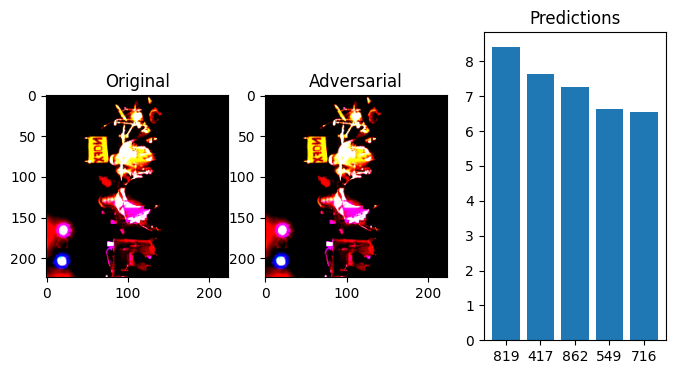

<Figure size 640x480 with 0 Axes>

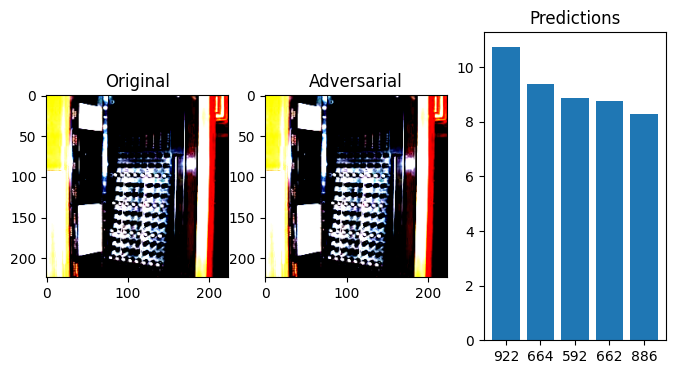

In [ ]:
criterion = nn.CrossEntropyLoss()
epsilon = 0.02
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
adversarial_correct = 0
attack_success = 0
total = 0
pretrained_model = pretrained_model.to(device)

# For visualization and analysis
targeted_success_rate = 0
untargeted_success_rate = 0

# Collect adversarial images and labels here
adv3_images_list = []
adv3_labels_list = []

# Choose a target class (e.g., 0 - could be 'plane' in CIFAR-10)
target_class = 0

for step, (images, targets) in enumerate(data_loader):
    images, targets = images.to(device), targets.to(device)

    # Apply the improved targeted attack
    improved_patch_adversarial_images = patch_improved_attack(
        pretrained_model,
        images,
        targets,
        epsilon=epsilon,
        alpha=0.002,  # Step size as fraction of epsilon
        iters=10,
        target_class=target_class  # Pass target_class here
    )

    # Store adversarial images and labels into lists
    adv3_images_list.append(improved_patch_adversarial_images.cpu())
    adv3_labels_list.append(targets.cpu())

    # Get model predictions on the adversarial examples (Improved Attack)
    with torch.no_grad():
        improved_patch_adversarial_outputs = pretrained_model(improved_patch_adversarial_images)
        _, improved_patch_adv_predicted = torch.max(improved_patch_adversarial_outputs.data, 1)

        # Untargeted success rate
        combined_untargeted_success = (improved_patch_adv_predicted != targets).sum().item()
        untargeted_success_rate += combined_untargeted_success

        # Targeted success rate
        if target_class is not None:
            combined_patch_targeted_labels = torch.full_like(targets, target_class)
        else:
            combined_patch_targeted_labels = (targets + 1) % improved_patch_adversarial_outputs.shape[1]

        combined_targeted_success = (improved_patch_adv_predicted == combined_patch_targeted_labels).sum().item()
        targeted_success_rate += combined_targeted_success

        total += targets.size(0)

    # Visualize the first batch (if needed)
    if step == 0:
        show_img(images, improved_patch_adversarial_images, improved_patch_adversarial_outputs, True)




In [ ]:
adv3_images_tensor = torch.cat(adv3_images_list, dim=0)
adv3_labels_tensor = torch.cat(adv3_labels_list, dim=0)

AdversarialTestSet3 = torch.utils.data.TensorDataset(adv3_images_tensor, adv3_labels_tensor)
adv3_data_loader = torch.utils.data.DataLoader(AdversarialTestSet3, batch_size=64, shuffle=False)



In [ ]:
adv3_acc, adv3_top5acc = get_accuracies(pretrained_model, adv3_data_loader)

top1 accuracy: 0.40%
top5 accuracy: 1.20%


## Task 5: Transferring Attacks

In [11]:
new_model = torchvision.models.densenet121(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 153MB/s]


In [ ]:
adv_acc_new, adv_top5acc_new = get_accuracies(new_model, adv_data_loader)

top1 accuracy: 48.20%
top5 accuracy: 71.00%


In [22]:
adv_acc_new2, adv_top5acc_new2 = get_accuracies(new_model, adv2_data_loader)

top1 accuracy: 73.40%
top5 accuracy: 92.60%


In [ ]:
adv_acc_new3, adv_top5acc_new3 = get_accuracies(new_model, adv3_data_loader)